# 텀 프로젝트 스핀오프 <비트코인을 예측해보아요>

그렇다면 이번엔 진짜로 비트코인 예측을 해봐야지 않겠는가?
지난 30일간의 시가,종가,고가,저가,변동률의 데이터로 오늘의 종가를 예측해주는 딥러닝 모델을 만들어보자. 여기서 쓸 모델은 RNN중 LSTM을 쓸 것이다.

참고로 이 코드는 내가 노트북밖에 없는 관계로 코랩으로 테스팅 되었다.(내 노트북은 학습하는데 하루종일 걸리는 것 같아서 코랩으로 했다.) 고로 로컬로는 에러가 날 수 있으니 유의바란다. 웬만하면 괜찮을 것이다.

필요한 라이브러리는 pandas, numpy, matplotlib, keras 이다

바로 아래 코드는 코랩에서 비트코인 데이터 파일을 불러오는 코드임으로 신경 쓰지 않아도 괜찮다.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

Saving Bitcoin.xlsx to Bitcoin.xlsx


비트코인 데이터 가져오기

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_excel("./Bitcoin.xlsx")
data = data.rename(columns={"날짜":"Date","종가":"Close","시가":"Open","고가":"High","저가":"Low","거래량":"Volume","변동 %":"Rate"})

# 중간에 데이터가 없거나, 비트코인 초반에는 거래량이 미미해서 빼 버렸다. 약 2010~2011까지 데이터 삭제
data.drop([4337+i for i in range(6)],axis = 0,inplace=True)
data.drop([i for i in range(4412,data.shape[0]+6)],axis=0,inplace=True)
data.drop("요일",axis=1,inplace=True)
data = data.reset_index(drop=True)

reversed_idx = [i for i in range(data.shape[0]-1,-1,-1)]
data = pd.DataFrame(data,index=reversed_idx)
data = data.reset_index(drop=True)

def IntVolume(value):
    value = str(value)
    if value[-1] == 'B':
        return int(float(value.strip('B')) * 1000000) # B: Billion
    elif value[-1] == 'M':
        return int(float(value.strip('M')) * 1000) # M: Million
    elif value[-1] == 'K':
        return int(float(value.strip('K'))) # K: Thousand


vol_data = data["Volume"].apply(IntVolume)
data.drop("Volume",axis=1,inplace=True)
# data["Volume"] = vol_data
print(data.head())
print(data.shape)
print(data.info())

        Date  Close  Open  High  Low    Rate
0 2011-04-12    0.9   0.8   0.9  0.8  0.1169
1 2011-04-13    0.9   0.9   1.0  0.9  0.0727
2 2011-04-14    1.0   0.9   1.0  0.9  0.0840
3 2011-04-15    1.0   1.0   1.1  0.9  0.0000
4 2011-04-16    1.0   1.0   1.1  1.0  0.0607
(4406, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4406 entries, 0 to 4405
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4406 non-null   datetime64[ns]
 1   Close   4406 non-null   float64       
 2   Open    4406 non-null   float64       
 3   High    4406 non-null   float64       
 4   Low     4406 non-null   float64       
 5   Rate    4406 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 206.7 KB
None


70%의 데이터는 훈련용으로 30%는 테스트용으로 분할 하였다. 참고로 여기서 학습할 요소는 하루당 시가,종가,고가,저가,변동률 5가지의 요소의 30일간의 데이터로 바로 오늘 종가를 예측하는 모델을 만드는 것이 목적이다.

In [ ]:
# 70% Train
# 30% Test
train_data_x = data.iloc[:int(data.shape[0]*0.7),:]
train_data_y = data["Close"].iloc[1:int(data.shape[0]*0.7+1):]
train_data_x = train_data_x.reset_index(drop=True)
train_data_y = train_data_y.reset_index(drop=True)
# print(train_data_x.tail())
# print(train_data_y.tail())
train_data_x.drop("Date",axis=1,inplace=True)
train_data_x = np.array(train_data_x)
train_data_y = np.array(train_data_y)

test_data_x = data.iloc[int(data.shape[0]*0.7):data.shape[0]-1:]
test_data_y = data["Close"].iloc[int(data.shape[0]*0.7)+1:]
test_data_x = test_data_x.reset_index(drop=True)
test_data_y = test_data_y.reset_index(drop=True)
print(test_data_x.head())
# print(test_data_y.tail())
test_data_x.drop("Date",axis=1,inplace=True)
test_data_x = np.array(test_data_x)
test_data_y = np.array(test_data_y)


def create_dataset(datasetX,datasetY, look_back):
  dataX, dataY = [], []
  for i in range(len(datasetX)-look_back):
    a = datasetX[i:(i+look_back)]
    dataX.append(a)
    dataY.append(datasetY[i+look_back-1])
  return np.array(dataX), np.array(dataY)

time_step = 30
trainX,trainY = create_dataset(train_data_x,train_data_y,time_step)
testX,testY = create_dataset(test_data_x,test_data_y,time_step)
# print(testX)
# print(testY)
# print(trainX[-2],trainX[-1])
# print(trainY)

        Date   Close    Open    High     Low    Rate
0 2019-09-27  8184.9  8063.8  8257.4  7882.1  0.0150
1 2019-09-28  8208.5  8184.5  8297.2  8031.1  0.0029
2 2019-09-29  8049.1  8208.0  8226.8  7922.1 -0.0194
3 2019-09-30  8284.3  8048.9  8318.5  7749.0  0.0292
4 2019-10-01  8302.7  8285.0  8486.2  8187.9  0.0022


In [ ]:
shaped_trainX = trainX.reshape(trainX.shape[0],time_step,5)
shaped_testX = testX.reshape(testX.shape[0],time_step,5)
print(shaped_trainX.shape)

(3054, 30, 5)


딥러닝 모듈은 keras를 사용하였다. 그 중 LSTM 모델을 이용하여 학습하였다. 이 모델은 기존 RNN방식의 장기 의존성 문제를 해결할 수 있다고 하여 이용하게 되었다. 그래서 과거의 데이터 반영에 효율적이다라는 평가를 받기에 사용하였다.
또한 직접 LSTM을 구현하는 일은 너무 오래 걸리기에 모듈을 이용하게 되었다.
활성화 함수는 기존 tanh함수에서 relu함수로 변경하였다. 이는 tanh으로 실험해보았을때 gradient vanishing 문제가 생기는 것 같아서 취한 조치이다. 다행이도 relu로 실행하니 유의미한 모듈을 만들 수 있었다. loss 함수로는 평균 제곱 오차 함수를 이용하였다.

    % 주의 % 여기서부터는 colab으로 진행했다. 로컬로 진행을 하지 않았으므로 사용자의 노트북/컴퓨터 성능에 따라 컴파일 시간이 꽤 길어질 수 있다.

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras

K.clear_session()
model = Sequential()
model.add(LSTM(40 ,activation='relu',input_shape=(time_step,5)))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error',optimizer=optimizer)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                7360      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 7,401
Trainable params: 7,401
Non-trainable params: 0
_________________________________________________________________


아래는 실제 학습 코드이다.

In [ ]:
early_stop = EarlyStopping(monitor='loss',patience=20,verbose=1)
model.fit(shaped_trainX, trainY, epochs=100,
          batch_size=32, verbose=1,callbacks=[early_stop])

Epoch 1/100
96/96 [==============================] - 2s 16ms/step - loss: 703352.5625
Epoch 2/100
96/96 [==============================] - 1s 13ms/step - loss: 550818.5000
Epoch 3/100
96/96 [==============================] - 1s 14ms/step - loss: 668784.1875
Epoch 4/100
96/96 [==============================] - 1s 14ms/step - loss: 510754.5312
Epoch 5/100
96/96 [==============================] - 1s 13ms/step - loss: 542038.4375
Epoch 6/100
96/96 [==============================] - 1s 14ms/step - loss: 570520.0000
Epoch 7/100
96/96 [==============================] - 2s 16ms/step - loss: 667068.7500
Epoch 8/100
96/96 [==============================] - 2s 22ms/step - loss: 489039.8750
Epoch 9/100
96/96 [==============================] - 1s 14ms/step - loss: 83636.2734
Epoch 10/100
96/96 [==============================] - 1s 13ms/step - loss: 273217.0625
Epoch 11/100
96/96 [==============================] - 1s 14ms/step - loss: 123345.4688
Epoch 12/100
96/96 [==============================] -

테스트를 위해서 앞서서 나누어둔 30%데이터를 내가 만든 모델에 넣어 실제 값과 비교하였다.

41/41 [==============================] - 0s 11ms/step


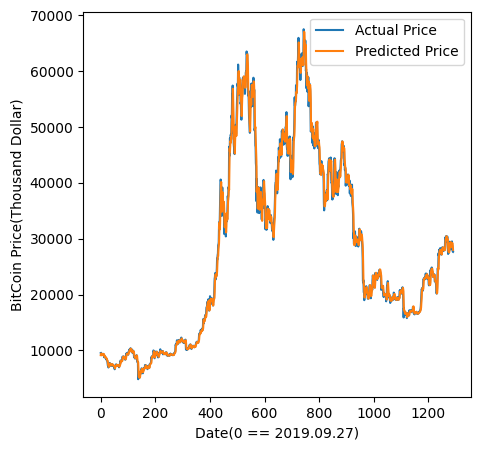

평균 오차율: 2.77%
(예측값/실제값) 의 평균: 0.99965
(오차율이 5% 이하인 경우 / 모든 경우): 0.869


In [ ]:
import matplotlib.pyplot as plt

testPredictY = model.predict(testX)
var1 = testY
var2 = testPredictY.T[0]
graphX = [i for i in range(len(var1))]

plt.figure(figsize=(5,5))
plt.plot(graphX,var1)
plt.plot(graphX,var2)
plt.ylabel(ylabel="BitCoin Price(Thousand Dollar)")
plt.xlabel(xlabel="Date(0 == 2019.09.27)")
plt.legend(["Actual Price","Predicted Price"])
plt.show()

# print(var2[:10])
# print(var1[:10])
accuracy = (np.absolute(var2-var1))/var1
print(f"평균 오차율: {round(accuracy.mean()*100,3)}%")
print(f"(예측값/실제값) 의 평균: {round((var2/var1).mean(),5)}")
print(f"(오차율이 5% 이하인 경우 / 모든 경우): {round(np.count_nonzero(np.round(accuracy,2)<=0.05)/accuracy.shape[0],3)}")


오차율이 약 5% 정도가 나야한다. 이보다 좀 큰 값이 도출된다며 학습 단계 코드를 다시 돌려보면 훨씬 좋은 예측률을 도출한다. 위 그래프는 2019년 9월 27일부터 2023년 5월 10일까지의 예측값과 실제값을 비교한 그래프이다.

----
### 결론: 오차율 5% 이내의 예측률을 보여주었다.

학습할때마다 예측률은 조금씩 바뀌므로 알아서 몇 번 돌리고 가장 예측률 좋은 것을 뽑아다가 쓰길 바란다. 개인적으로 가장 좋았던 모듈은 평균 오차율이 2.77%정도 되었다.
아무튼 그래프를 보다 싶이 추측값이 실제와 거의 유사한 그래프를 그렸다. 고로 어느정도 비트코인 종가를 예측할 수 있을 거라고 판단한다.

_____

### 실전코드: mark1.py

이제 이 프로그램을 24시간 돌려줄 컴퓨터가 필요하긴 하다. upbit api키와 계좌는있어서 매수매도는 문제가 없으나 서버가 없다. 내 노트북을 24시간 켜 둘 수는없지 않은가? 사실 이 모델로 학습된 값을 이용한 실전자동매매 코드는 이미 짜두었다. 이건 mark1.py 파일로 볼 수 있다. 아직 실제로 장기간 돌려보지는 못했다. AWS ec2 서비스에 tensorflow가 용량 부족으로 안 깔렸기때문이다. 조만간 용량을 늘려서 실제로 실행해보고자 한다. 참고로 실전코드에 쓰이는모델은 saved_model파일에 미리 세이브 해둔 모델이다.

그리고 실전코드는 지금 보신 모델(비트코인 달러 예측)과 달리 비트코인 원화 가격을 예측하는 모델을 이용한다. 이는 upbit에서는 원화로만 거래 되기 때문이다.

실전코드의 원리를 대충 설명하자면 upbit api를 통해 최근 30일치의 데이터를 가지고와 모델에 넣어 오늘 종가를 예측한다. 예측된 종가보다 오늘 시가가 더 낮다면 비트코인 전량 매수하고 현재가가 예측된 종가보다 높아지면 이를 모두 매도한다. 아침 8:59에는 가지고 있는 모든 비트코인을 매도한다.

참고로 엑세스 키와 시크릿 키를 일부로 빼 놓았으므로 작동되지는 않을 것이다 :)
아직은 재미로만 보길 바란다.
_____



